<a href="https://colab.research.google.com/github/ASHIKAMOHAN/GalaxyProject/blob/main/GalaxyDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
import pickle
import os
from google.colab import drive



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function to load datasets
def load_data():
    happy_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_D.txt'
    ]
    teddy_files = [
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_D.txt'
    ]

    happy_dfs = [pd.read_csv(file, delimiter='\t') for file in happy_files]
    teddy_dfs = [pd.read_csv(file, delimiter='\t', skiprows=6) for file in teddy_files]

    return happy_dfs, teddy_dfs




In [4]:
# Load datasets
happy_dfs, teddy_dfs = load_data()

# Define the correct column names
column_names = ['id', 'mag_r', 'u-g', 'g-r', 'r-i', 'i-z', 'z_spec', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5']

In [5]:
# Clean and rename columns
def clean_and_rename_columns(dfs, column_names):
    cleaned_dfs = []
    for df in dfs:
        if df.shape[1] == 1:
            df = df.iloc[:, 0].str.split(expand=True)
        df.columns = column_names
        cleaned_dfs.append(df)
    return cleaned_dfs

# Apply the function to all datasets
happy_dfs = clean_and_rename_columns(happy_dfs, column_names)
teddy_dfs = clean_and_rename_columns(teddy_dfs, column_names)



In [6]:
# Preprocess data
def preprocess_data(df):
    X = df.drop('z_spec', axis=1).astype(float)
    y = df['z_spec'].astype(float)
    return X, y

# Preprocess the datasets
# Happy datasets
X_train_happy, y_train_happy = preprocess_data(happy_dfs[0])  # Happy A: Training/Calibration set
X_val_happy, y_val_happy = preprocess_data(happy_dfs[1])      # Happy B: Validation set
X_test_happy, y_test_happy = preprocess_data(happy_dfs[2])    # Happy C: Validation set
# Happy D is not used

# Teddy datasets
X_train_teddy, y_train_teddy = preprocess_data(teddy_dfs[0])  # Teddy A: Training/Calibration set
X_val_teddy, y_val_teddy = preprocess_data(teddy_dfs[1])      # Teddy B: Validation set
X_test_teddy, y_test_teddy = preprocess_data(teddy_dfs[2])    # Teddy C: Validation set
# Teddy D is not used

# Combine Happy and Teddy datasets for a comprehensive training set
X_train = pd.concat([X_train_happy, X_train_teddy])
y_train = pd.concat([y_train_happy, y_train_teddy])

X_val = pd.concat([X_val_happy, X_val_teddy])
y_val = pd.concat([y_val_happy, y_val_teddy])

X_test = pd.concat([X_test_happy, X_test_teddy])
y_test = pd.concat([y_test_happy, y_test_teddy])



In [7]:
# Check for and handle NaN values
def handle_nan(df):
    if df.isnull().values.any():
        df = df.fillna(df.mean())
    return df

# Apply NaN handling to datasets
X_train = handle_nan(X_train)
X_val = handle_nan(X_val)
X_test = handle_nan(X_test)
y_train = handle_nan(y_train)
y_val = handle_nan(y_val)
y_test = handle_nan(y_test)

# Verify no NaN values are present
def verify_no_nan(df, name):
    if df.isnull().values.any():
        print(f"NaN values found in {name}")
    else:
        print(f"No NaN values in {name}")

# Verify all datasets
verify_no_nan(X_train, 'X_train')
verify_no_nan(X_val, 'X_val')
verify_no_nan(X_test, 'X_test')
verify_no_nan(y_train, 'y_train')
verify_no_nan(y_val, 'y_val')
verify_no_nan(y_test, 'y_test')

No NaN values in X_train
No NaN values in X_val
No NaN values in X_test
No NaN values in y_train
No NaN values in y_val
No NaN values in y_test


In [8]:
# Load weights
def load_weights():
    weight_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_D.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_D.txt'
    ]
    weights = [pd.read_csv(file, delimiter='\t', header=None).values.flatten() for file in weight_files]
    return weights

weights = load_weights()

# Adjust weights lengths to match validation and test sets
def adjust_weights(weights, X_val_happy, X_val_teddy, X_test_happy, X_test_teddy):
    len_val_happy = len(X_val_happy)
    len_val_teddy = len(X_val_teddy)
    len_test_happy = len(X_test_happy)
    len_test_teddy = len(X_test_teddy)

    weights_val = np.concatenate([weights[0][:len_val_happy], weights[3][:len_val_teddy]])
    weights_test = np.concatenate([weights[1][:len_test_happy], weights[4][:len_test_teddy]])

    # If weights_val is shorter than X_val, we fill the rest with 1s to match the length
    if len(weights_val) < len(X_val):
        weights_val = np.concatenate([weights_val, np.ones(len(X_val) - len(weights_val))])

    # If weights_test is shorter than X_test, we fill the rest with 1s to match the length
    if len(weights_test) < len(X_test):
        weights_test = np.concatenate([weights_test, np.ones(len(X_test) - len(weights_test))])

    return weights_val, weights_test

weights_val, weights_test = adjust_weights(weights, X_val_happy, X_val_teddy, X_test_happy, X_test_teddy)

In [9]:
# Check for consistency in data lengths
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))
print("Length of weights_val:", len(weights_val))
print("Length of X_test:", len(X_test))
print("Length of y_test:", len(y_test))
print("Length of weights_test:", len(weights_test))

Length of X_train: 149259
Length of y_train: 149259
Length of X_val: 149457
Length of y_val: 149457
Length of weights_val: 149457
Length of X_test: 158295
Length of y_test: 158295
Length of weights_test: 158295


In [21]:
# Model training functions

# Random Forest
def train_random_forest(X_train, y_train, X_val, y_val, weights_train, weights_val):
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train, sample_weight=weights_train)
    y_pred_rf = rf.predict(X_val)
    rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False, sample_weight=weights_val)
    r2_rf = r2_score(y_val, y_pred_rf)
    mae_rf = mean_absolute_error(y_val, y_pred_rf)
    medae_rf = median_absolute_error(y_val, y_pred_rf)
    return y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf

# Gradient Boosting
def train_gradient_boost(X_train, y_train, X_val, y_val, weights_train, weights_val):
    gb = GradientBoostingRegressor()
    gb.fit(X_train, y_train, sample_weight=weights_train)
    y_pred_gb = gb.predict(X_val)
    rmse_gb = mean_squared_error(y_val, y_pred_gb, squared=False, sample_weight=weights_val)
    r2_gb = r2_score(y_val, y_pred_gb)
    mae_gb = mean_absolute_error(y_val, y_pred_gb)
    medae_gb = median_absolute_error(y_val, y_pred_gb)
    return y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb



In [27]:
def train_decision_tree(X_train, y_train, X_val, y_val, weights_train=None, weights_val=None):
    dt = DecisionTreeRegressor()
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_val)
    rmse_dt = mean_squared_error(y_val, y_pred_dt, squared=False)
    r2_dt = r2_score(y_val, y_pred_dt)
    mae_dt = mean_absolute_error(y_val, y_pred_dt)
    medae_dt = median_absolute_error(y_val, y_pred_dt)
    return y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt

In [12]:

# Support Vector Regression (from scratch using gradient descent)
class SVRScratch:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        n = len(y)

        for epoch in range(self.epochs):
            for i in range(n):
                if y[i] * (np.dot(X[i], self.w) + self.b) < 1:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(X[i], y[i]))
                    self.b -= self.learning_rate * y[i]
                else:
                    self.w -= self.learning_rate * 2 * self.lambda_param * self.w

    def predict(self, X):
        return np.dot(X, self.w) + self.b

In [13]:


class GAMScratch:
    def __init__(self, X, y, feature_indices):
        self.X = X
        self.y = y
        self.feature_indices = feature_indices
        self.models = []

    def fit(self):
        for feature_index in self.feature_indices:
            # Sort the data by the feature to ensure it's increasing
            sorted_indices = np.argsort(self.X[:, feature_index])
            sorted_X = self.X[sorted_indices, feature_index]
            sorted_y = self.y[sorted_indices]

            spline = UnivariateSpline(sorted_X, sorted_y, s=1)
            self.models.append(spline)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for model, feature_index in zip(self.models, self.feature_indices):
            predictions += model(X[:, feature_index])
        return predictions

In [14]:
# K-Nearest Neighbors (KNN) from scratch
class KNNScratch:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_val):
        y_pred = np.zeros(X_val.shape[0])
        for i, x in enumerate(X_val):
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_indices= np.argsort(distances)[:self.k]
            y_pred[i] = np.mean(self.y_train[k_indices])
            return y_pred

In [15]:
# Ensure weights_train is consistent
weights_train = np.ones(len(X_train))

In [24]:
y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf = train_random_forest(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Random Forest RMSE: {rmse_rf}, R2: {r2_rf}, MAE: {mae_rf}, MedAE: {medae_rf}')

Random Forest RMSE: 0.045428954999561434, R2: 0.9222066145624073, MAE: 0.02639088434379119, MedAE: 0.016381759999999912


In [25]:
y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb = train_gradient_boost(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Gradient Boost RMSE: {rmse_gb}, R2: {r2_gb}, MAE: {mae_gb}, MedAE: {medae_gb}')

Gradient Boost RMSE: 0.04674149086677657, R2: 0.9176177527328099, MAE: 0.028318579402515906, MedAE: 0.018409435359427073


In [28]:
# Train and evaluate Decision Tree
y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt = train_decision_tree(X_train, y_train, X_val, y_val)
print(f'Decision Tree RMSE: {rmse_dt}, R2: {r2_dt}, MAE: {mae_dt}, MedAE: {medae_dt}')

Decision Tree RMSE: 0.06306036484946376, R2: 0.8495305025294588, MAE: 0.036834102879088976, MedAE: 0.022633


In [29]:
svr_scratch = SVRScratch()
svr_scratch.fit(X_train.values, y_train.values)
y_pred_svr_scratch = svr_scratch.predict(X_val.values)
rmse_svr_scratch = mean_squared_error(y_val, y_pred_svr_scratch, squared=False)
r2_svr_scratch = r2_score(y_val, y_pred_svr_scratch)
mae_svr_scratch = mean_absolute_error(y_val, y_pred_svr_scratch)
medae_svr_scratch = median_absolute_error(y_val, y_pred_svr_scratch)
print(f'Support Vector Regression Scratch RMSE: {rmse_svr_scratch}, R2: {r2_svr_scratch}, MAE: {mae_svr_scratch}, MedAE: {medae_svr_scratch}')

Support Vector Regression Scratch RMSE: 1.893946481789197e+20, R2: -1.357284588367e+42, MAE: 1.893946481746221e+20, MedAE: 1.8939451692221858e+20


In [31]:
X_train_combined = np.concatenate((X_train.values, y_train.values.reshape(-1, 1)), axis=1)
gam_scratch = GAMScratch(X_train_combined, y_train.values, feature_indices=[1, 2, 3, 4, 5])
gam_scratch.fit()
y_pred_gam_scratch = gam_scratch.predict(X_val.values)
rmse_gam_scratch = mean_squared_error(y_val, y_pred_gam_scratch, squared=False)
r2_gam_scratch = r2_score(y_val, y_pred_gam_scratch)
mae_gam_scratch = mean_absolute_error(y_val, y_pred_gam_scratch)
medae_gam_scratch = median_absolute_error(y_val, y_pred_gam_scratch)
print(f'GAM Scratch RMSE: {rmse_gam_scratch}, R2: {r2_gam_scratch}, MAE: {mae_gam_scratch}, MedAE: {medae_gam_scratch}')

Decision Tree RMSE: 0.06284995738998657


In [30]:
knn_scratch = KNNScratch(k=5)
knn_scratch.fit(X_train.values, y_train.values)
y_pred_knn_scratch = knn_scratch.predict(X_val.values)
rmse_knn_scratch = mean_squared_error(y_val, y_pred_knn_scratch, squared=False)
r2_knn_scratch = r2_score(y_val, y_pred_knn_scratch)
mae_knn_scratch = mean_absolute_error(y_val, y_pred_knn_scratch)
medae_knn_scratch = median_absolute_error(y_val, y_pred_knn_scratch)
print(f'KNN Scratch RMSE: {rmse_knn_scratch}, R2: {r2_knn_scratch}, MAE: {mae_knn_scratch}, MedAE: {medae_knn_scratch}')

KNN Scratch RMSE: 0.3744635007212745, R2: -4.305844262332425, MAE: 0.33733493157764444, MedAE: 0.334364


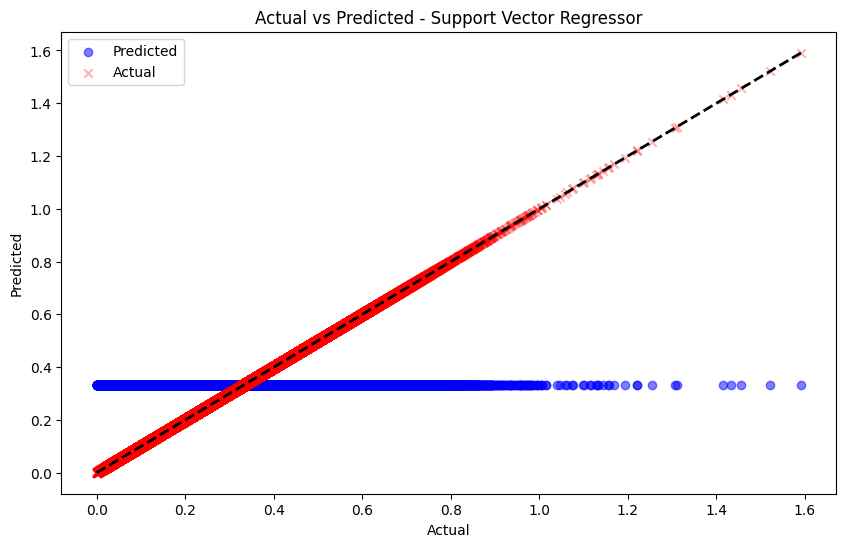

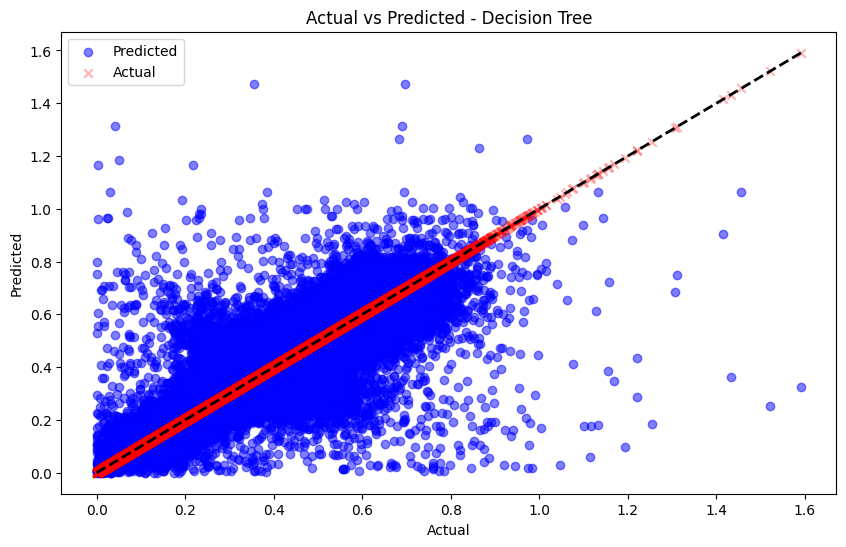

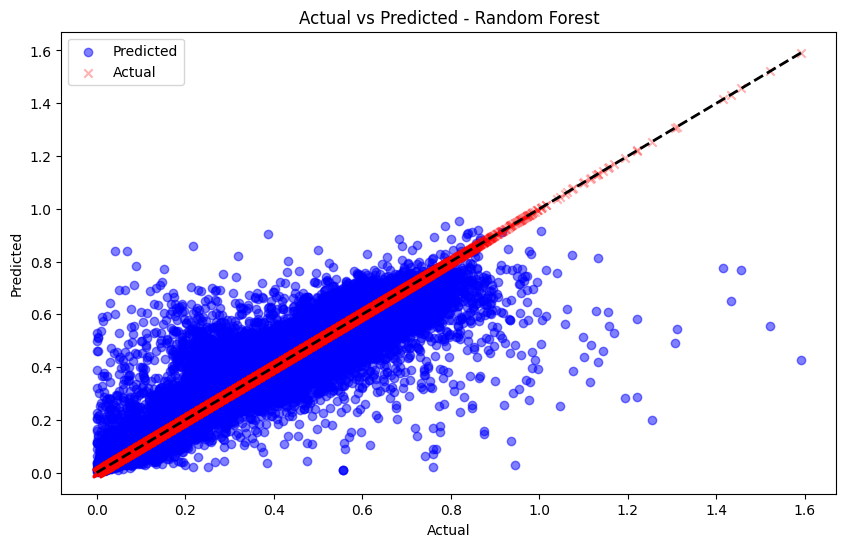

In [ ]:
def visualize_results(y_test, predictions, labels):
    for y_pred, label in zip(predictions, labels):
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, label='Predicted', color='blue', alpha=0.5, marker='o')
        plt.scatter(y_test, y_test, label='Actual', color='red', alpha=0.3, marker='x')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs Predicted - {label}')
        plt.legend()
        plt.show()

predictions = [y_pred_rf, y_pred_gb, y_pred_svr_scratch, y_pred_gam_scratch, y_pred_knn_scratch]
labels = ['Random Forest', 'Gradient Boost', 'SVR Scratch', 'GAM Scratch', 'KNN Scratch']

visualize_results(y_val, predictions, labels)